# UQ for an Optical Potential using ROSE

In [4]:
# (if you don't have it already)


In [10]:
# pip install nuclear-rose 

In [9]:
# pip install corner

In [8]:
# pip install surmise

In [41]:
import rose
import numpy as np
import time
import os
from scipy.stats import qmc
import matplotlib.pyplot as plt
import scipy.stats as sps
from tqdm import tqdm
import random
import datetime
import corner
import surmise
from surmise.emulation import emulator
from surmise.calibration import calibrator
from matplotlib.ticker import MaxNLocator




### Setting up the Scattering System

In [3]:
A = 40  # mass of the target
# asymptotic energy and wavenumber in center-of-mass (COM) frame
energy = 14  # MeV
# how many partial waves should we calculate?
l_max = 10
l_list = list(range(l_max + 1))
# domain of the differential cross section; the observable we want to emulate. We are setting them as equally spaced angles between 1 and 179 but this can be changed
angles = np.linspace(1, 179, 179)


### Next we either provide the experimental data we want to use, or a subset of angles and ROSE will generate mock data on them later

In [4]:
flag_provided_data =0  #Leave this as zero if user is only providing the "x" locations (the angles)



##################################################
#If providing data directly:
# angles_theta=
# anglesX=angles_theta- np.full(len(angles_theta), 1) #Moving the angles location by one because of how python works
# y_measured =   #Valueus of the observed cross section
# yerr=  #Errors of the observed cross section
# flag_provided_data=1    #Mark this as "1" if data is provided by user
##################################################


##################################################
#A subset of the angles in which we will deal with data
angles_theta=np.arange(20,160,5)
anglesX=angles_theta- np.full(len(angles_theta), 1) #Moving the angles location by one because of how python works

##################################################

### Finally some details and constants

In [5]:


AMU = 931.494102  # MeV/c^2, Particle Data Group
MASS_N = 1.008665 * AMU  # MeV/c^2 PDG
MASS_P = 1.007276 * AMU  # MeV/c^2 PDG
MASS_CHARGED_PION = 139.57039  # MeV/c^2
B_40CA = 342.0522  # BMEX

MASS_40CA = 20 * MASS_P + 20 * MASS_N - B_40CA
MU = (
    MASS_40CA * MASS_N / (MASS_40CA + MASS_N)
)  # reduced mass - we will do calculations in COM frame

#Alternatively you could define it as:
#MU = (AMU * A / (A+1)  ) 


k = np.sqrt(2 * MU * energy) / rose.constants.HBARC

rho=np.linspace(1e-6, 8*np.pi,2000)
s_0=6 * np.pi

## Defining the potentials

In [6]:
# shape of interaction for volume term
def wood_saxon(r, R, a):
    return 1 / (1 + np.exp((r - R) / a))


# shape of interaction for surface-peaked and spin-orbit coupling terms
def wood_saxon_prime(r, R, a):
    return -1 / a * np.exp((r - R) / a) / (1 + np.exp((r - R) / a)) ** 2


# total potential with a real and central term (with the same geometry)
# and imaginary surface-peaked term, but no SO coupling
def optical_potential(r, theta):
    Vv, Wv, Wd, Vso, Rv, Rd, Rso, av, ad, aso = theta
    return (-1j * Wv - Vv) * wood_saxon(r, Rv, av) + (4j * ad * Wd) * wood_saxon_prime(
        r, Rd, ad
    )


# spin orbit interaction constant
mso = rose.constants.HBARC / MASS_CHARGED_PION


# spin-orbit (SO) coulpling term - a function of l dot s, l being the orbital angular momentum
# and s being the spin of the neutron
def spin_orbit_potential(r, theta, ldots):
    Vv, Wv, Wd, Vso, Rv, Rd, Rso, av, ad, aso = theta
    return (Vso) * mso**2 * ldots * wood_saxon_prime(r, Rso, aso) / r


# the total number of parameters
nparams = 10

## Defining the parameters central value and the box around which we will train with the emulator

In [7]:
# This is the value of the parameters coming from the Koning-Delaroche parametrization.
# Taken from https://www-nds.iaea.org/RIPL-3/
VvKD = 48.9
WvKD = 1.2
WdKD = 7.7
VsoKD = 5.5


RvKD = 1.19* 40 ** (1.0 / 3.0)
RdKD = 1.29* 40 ** (1.0 / 3.0)
RsoKD = 1.00 * 40 ** (1.0 / 3.0)

avKD = 0.67
adKD = 0.67
asoKD = 0.59

alphaKD = np.array(
    [VvKD, WvKD, WdKD, VsoKD, RvKD, RdKD, RsoKD, avKD, adKD, asoKD]
)



#The following are the center of the parameters to train the emulator
Vv0 = 45
Wv0 = 2
Wd0 = 5
Vso = 5



Rv0 = 4

Rd0 = 4
Rso = 4

av0 = 0.5

ad0 = 0.5
aso = 0.5


#This is the center of our prior and around where we will train our RBM emulator
alphaCentral = np.array([Vv0, Wv0, Wd0, Vso, Rv0, Rd0, Rso, av0 , ad0, aso])





scaleTraining = 0.3

bounds = np.array(
    [
        alphaCentral - np.fabs(alphaCentral * scaleTraining),
        alphaCentral + np.fabs(alphaCentral * scaleTraining),
    ]
).T


def sample_points(npoints, bounds,initial_seed=None):
    sampler = qmc.LatinHypercube(d=len(bounds), seed=initial_seed)
    sample = sampler.random(npoints)
    scaled = qmc.scale(sample, bounds[:, 0], bounds[:, 1])
    return scaled

### Now we specify how many samples we want for training the emulator (both wave function  and operator expansion), and how many for testing 

In [11]:
n_train = 30

seed_train=142857
training_samples = sample_points(n_train, bounds,initial_seed=seed_train)
# np.savetxt("train_params_calibration.txt",training_samples)

In [12]:
n_train_EIM=1000

seed_EIM=142857*3

train_EIM = sample_points(n_train_EIM, bounds,initial_seed=seed_EIM)
# np.savetxt("train_params_EIM_calibration.txt",train_EIM)

In [13]:
n_test=10
seed_test=142857*2

test_samples = sample_points(n_test, bounds,initial_seed=seed_test)


# np.savetxt("test_params_calibration.txt",test_samples)

In [14]:
n_basis = 15
n_eim = 15

interactions = rose.InteractionEIMSpace(
    optical_potential,
    nparams,
    MU,
    energy,
    l_max,
    training_info=train_EIM,
    is_complex=True,
    spin_orbit_potential=spin_orbit_potential,
    explicit_training = True,
    rho_mesh=rho,
    n_basis=n_eim,
)



In [16]:

saeMCMC_fullangles = rose.ScatteringAmplitudeEmulator.from_train(
    interactions,
    training_samples,
    l_max,
    s_mesh=rho,
    s_0=s_0,
    n_basis=n_basis,
    angles=angles/ 180 * np.pi,
    hf_tols=[
        10 ** (-7),
        10 ** (-7),
    ],
)

  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [00:32<00:00,  2.93s/it]
/home/codespace/.python/current/lib/python3.10/site-packages/rose/utility.py:86: RuntimeWarning: divide by zero encountered in scalar divide
  return np.hstack([1/(2*s_c) * (3 - (s[ii]/s_c)**2), 1/s[jj]])


In [17]:
# calculate the exact differential cross section for the test parameters we sampled
test_CS = []
for params in tqdm(test_samples):
    test_CS.append(saeMCMC_fullangles.exact_dsdo(params))

100%|██████████| 10/10 [00:40<00:00,  4.00s/it]


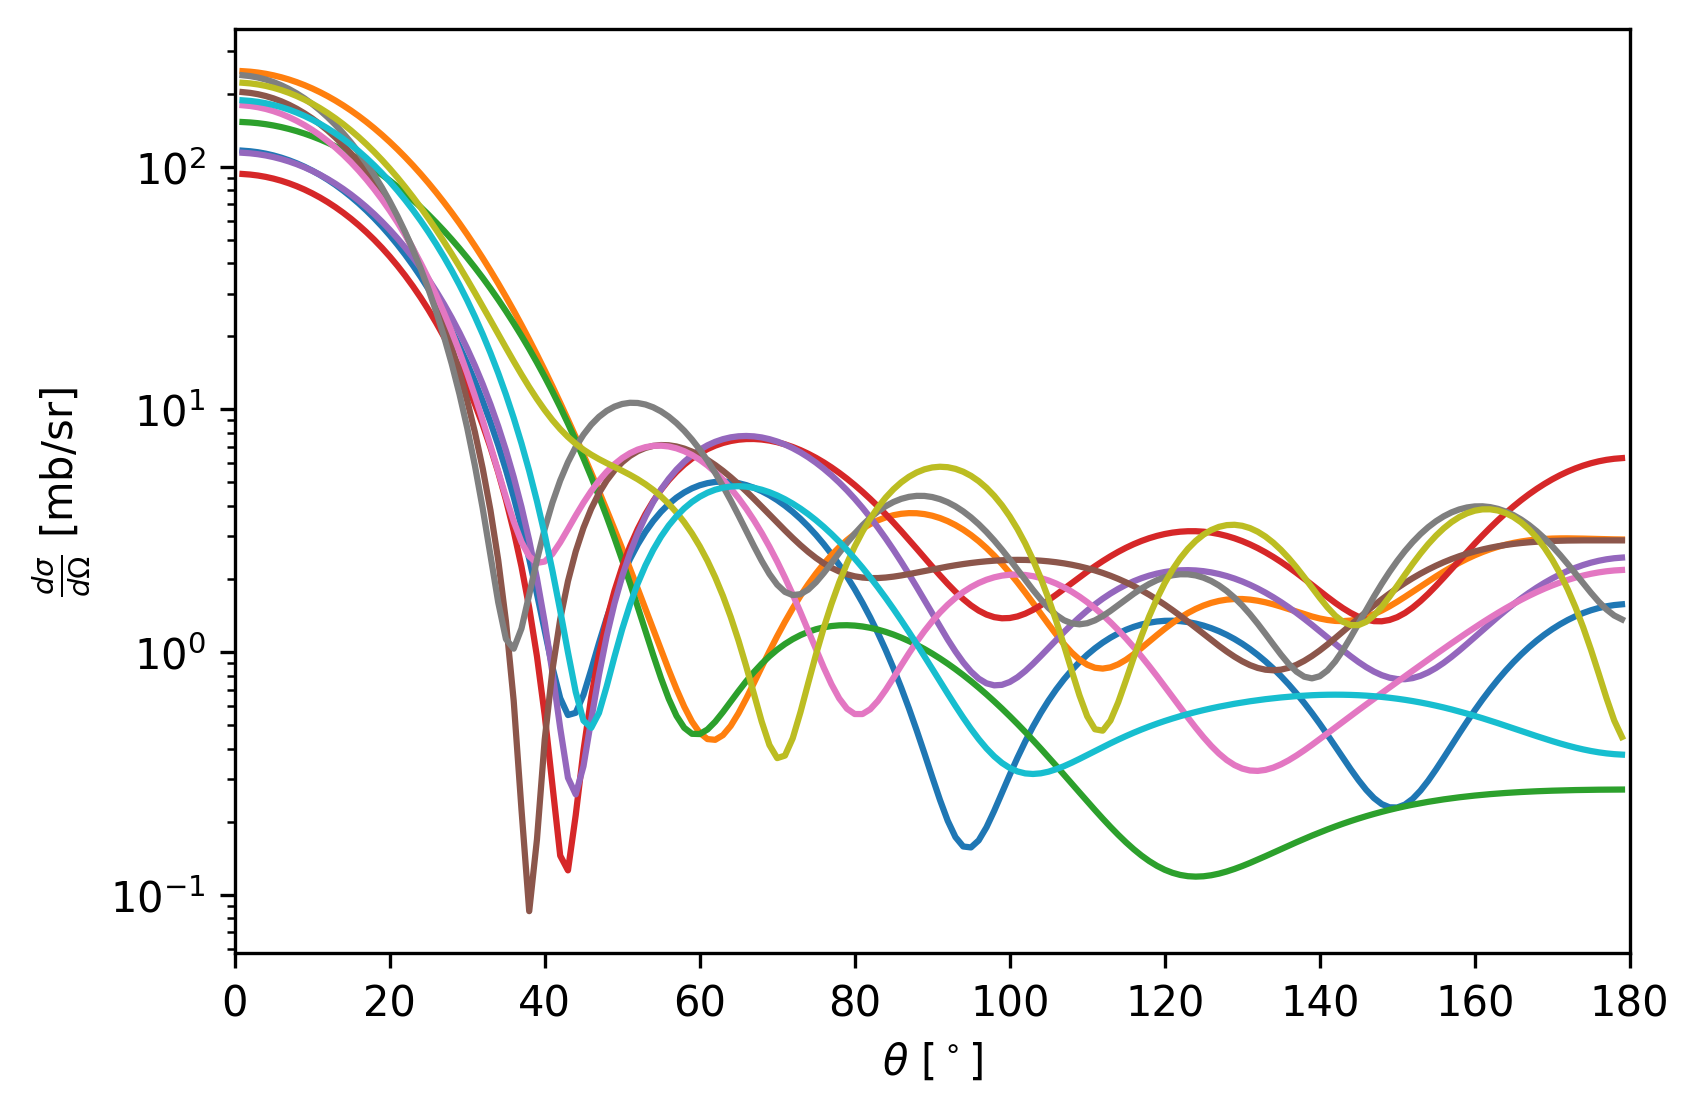

In [18]:
# now let's plot the differential scattering cross section for each of these samples test points!
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
fig.patch.set_facecolor("white")


for i in range(n_test):
    ax.plot(angles, test_CS[i])
ax.set_yscale("log")
plt.xlim([0, 180])
plt.xlabel(r"$\theta$ [$^\circ$]")
plt.ylabel(r"$\frac{d \sigma}{d \Omega}$ [mb/sr]")
plt.show()

### Lets have some quantification on the level of error that the emulator is making across the test set. You can also start getting a feeling for its timing

In [27]:
prediction_list = []
times_list = []
for i in range(len(test_samples)):
        st = time.time()
        predicted = saeMCMC_fullangles.emulate_dsdo(test_samples[i])
        et = time.time()
        prediction_list.append(predicted)
        times_list.append(et - st)

residual_list_relative = []
residual_list_all = []
residual_list_median = []


#Calculating residuals over all the angles:
for i in range(len(test_samples)):
    residual_list_relative.append(
        100* np.fabs((prediction_list[i] - test_CS[i])) / (test_CS[i])
    )
    residual_list_median.append(np.median(residual_list_relative[i]))
    residual_list_all.append(prediction_list[i] - test_CS[i])
residual_list_relative = np.array(residual_list_relative)    
residual_list_all=np.array(residual_list_all)

### We can now plot the error for each angle. If you selected just a few test cases the histograms might look a bit empty

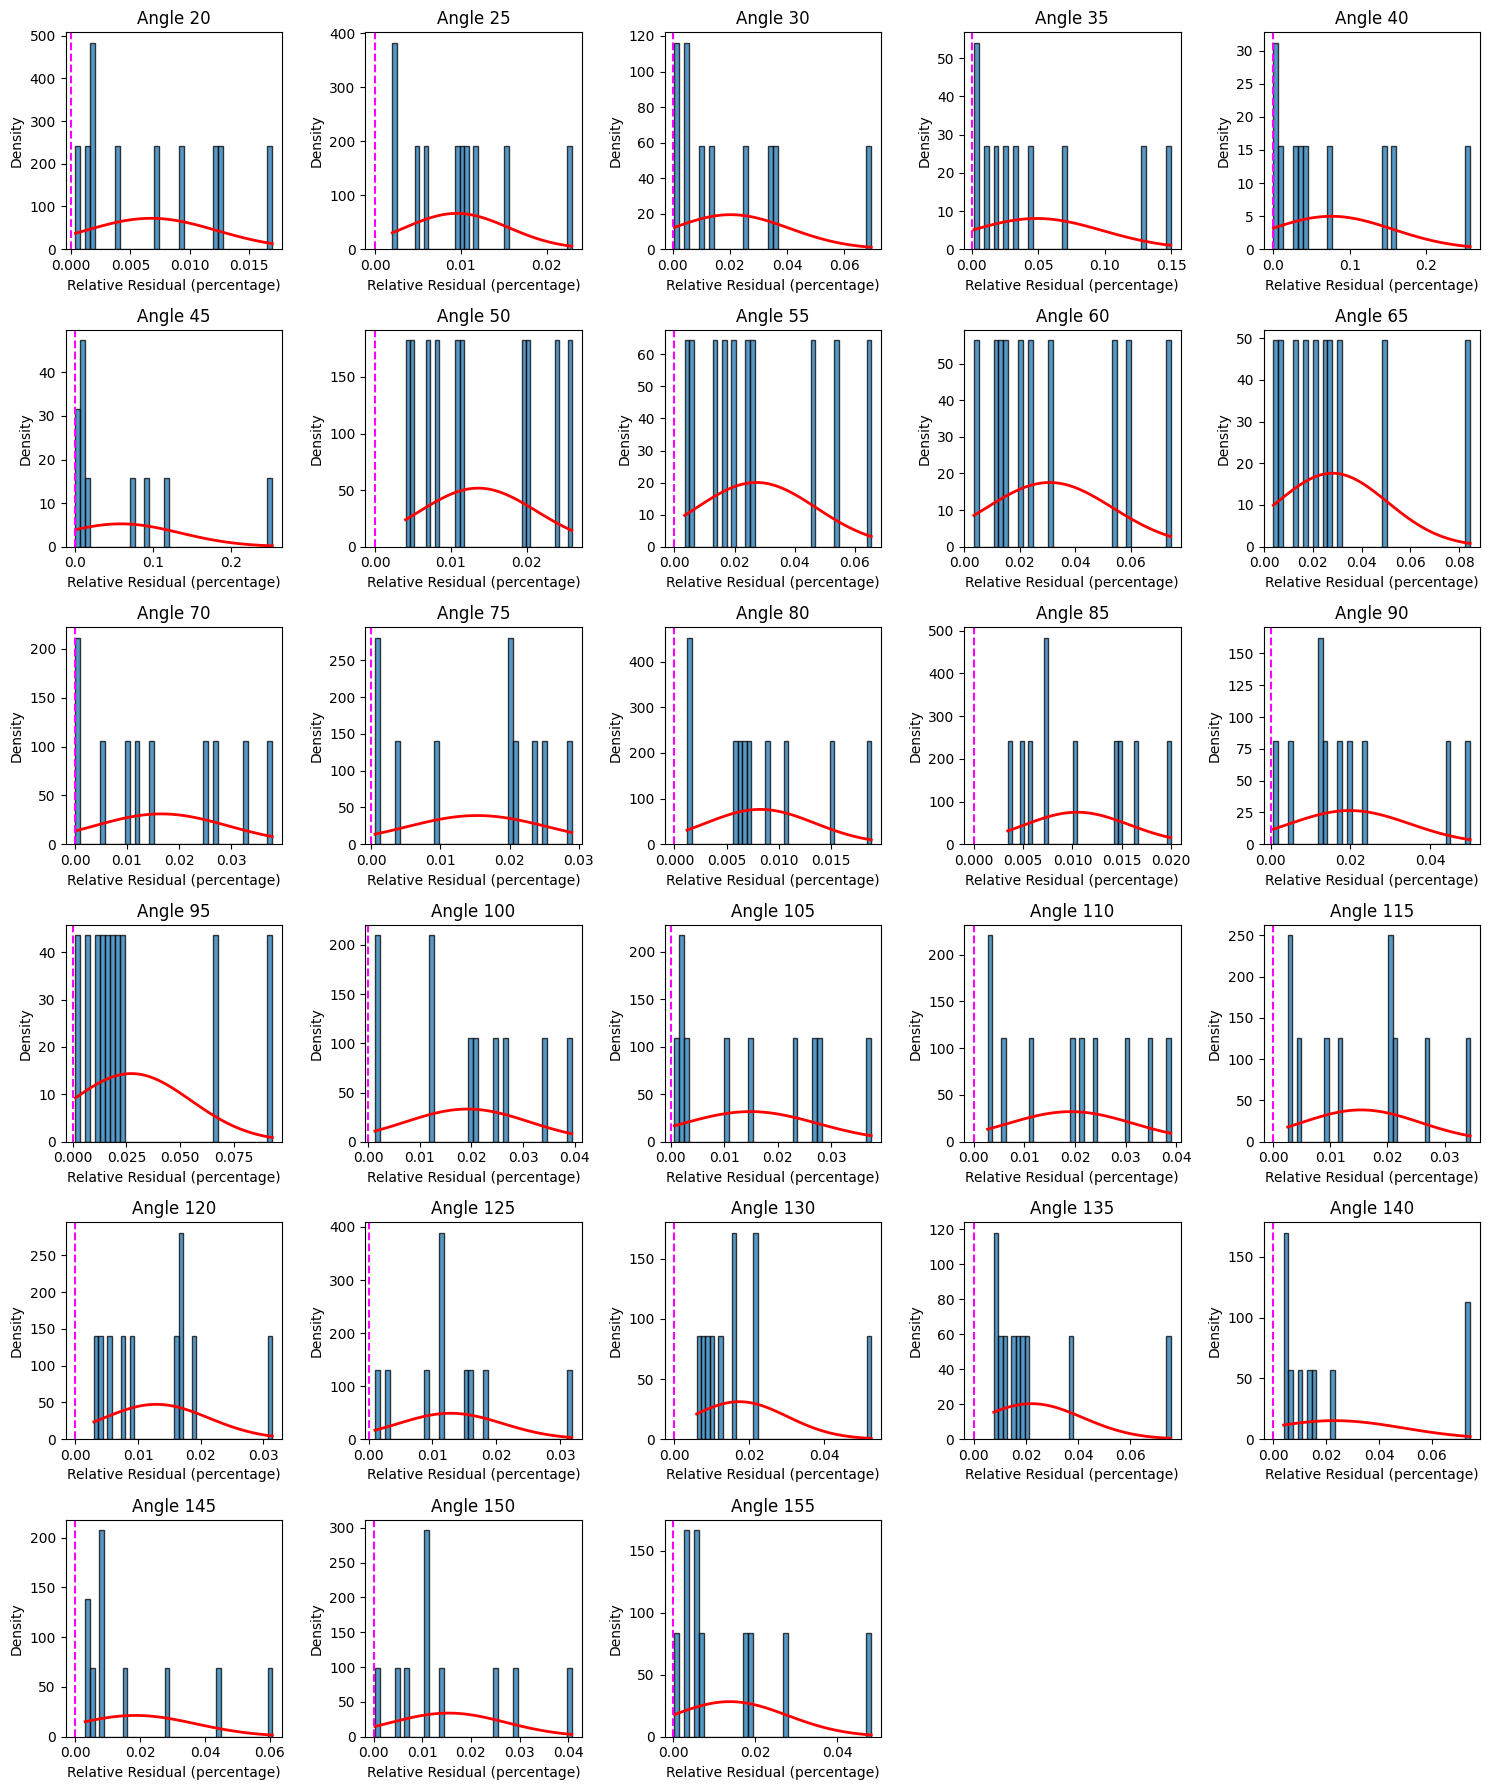

In [28]:

rmse_list=[]
residuals=residual_list_relative.T[anglesX]

plots_per_row = 5
num_of_rows = len(residuals) // plots_per_row + (len(residuals) % plots_per_row > 0)

# Set up the figure size, you can adjust it as needed
plt.figure(figsize=(15, num_of_rows * 3))

# Loop over the list of residuals and create a histogram for each
for i, residual in enumerate(residuals):
    # Create a subplot for each histogram
    ax=plt.subplot(num_of_rows, plots_per_row, i + 1)
    
#     # Plot the histogram
#     plt.hist(residual, bins=20, alpha=0.75, edgecolor='black', density=True)
    
    # Plot the histogram and normalize it
    ax.hist(residual, bins=40, alpha=0.75, edgecolor='black', density=True)

    
    
    # Fit a Gaussian distribution to the residuals
    mu=np.mean(residuals[i])
    std = np.std(residuals[i])
    rmse_list.append(np.sqrt(mu**2+std**2))

    
    # Plot the Gaussian distribution
    xmin=np.min(residuals[i])
    xmax = np.max(residuals[i])

    x = np.linspace(xmin, xmax, 100)
    p = sps.norm.pdf(x, mu, std)
    ax.plot(x, p, 'r', linewidth=2)
    
                     
                     
    ax.axvline(x=0, color='magenta', linestyle='--', linewidth=1.5)
    # Optional: Set a title or labels
    plt.title(f'Angle {anglesX[i]+1}')
    plt.xlabel('Relative Residual (percentage)')
    plt.ylabel('Density')
    
    # Optional: Set a tight layout so the plots are neatly arranged
    plt.tight_layout()

# Show the plot
plt.show()

## Generating the pseudo data

In [30]:
if flag_provided_data==0:

    #Percentage error to be used in the cs
    sigma_err=0.1

    # Defining the data we are interest in

    #Angles Matched to reproduce Figure 6 from: https://iopscience.iop.org/article/10.1088/1361-6471/abba72

    angles_theta=np.arange(20,160,5)


    anglesX=angles_theta- np.full(len(angles_theta), 1) #Moving the angles location by one because of how python works
    f_exact = saeMCMC_fullangles.exact_dsdo(alphaKD)

    
    yperfect =f_exact[anglesX]
    yerr=yperfect*sigma_err

    np.random.seed(142857)

    y_measured=[]

    for i in range(len(yperfect)):
        y_measured.append(yperfect[i]+np.random.normal(0, yperfect[i]*sigma_err))
    
    y_measured=np.array(y_measured)



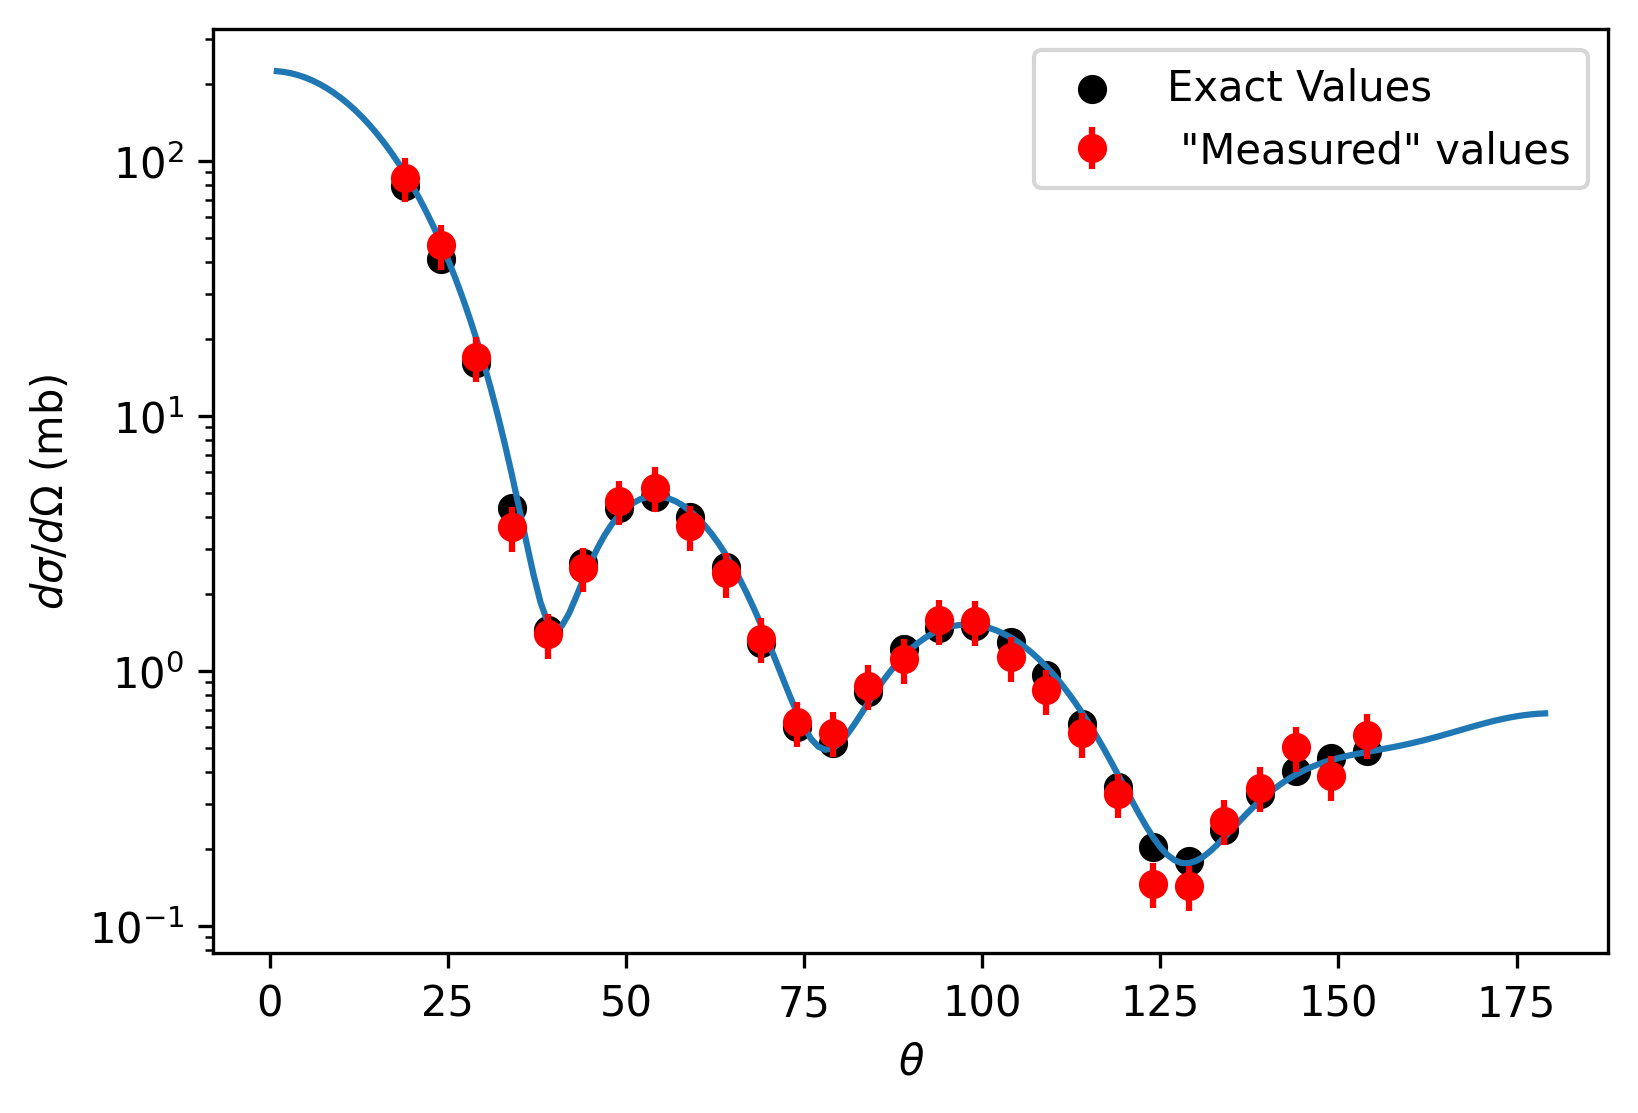

In [31]:
#Modify accordingly if you provided the experimental data directly (flag_provided_data==1)
fig, ax = plt.subplots(figsize=(6,4),dpi=300)
fig.patch.set_facecolor('white')


ax.plot(angles,f_exact)
ax.scatter(anglesX, yperfect,color='k',label='Exact Values')
# ax.scatter(anglesX, y_measured,color='r',label=' "Measured" values')
ax.errorbar(anglesX, y_measured, yerr=np.array(y_measured)*0.2, fmt="o", c="r",label=' "Measured" values')

ax.legend()

ax.set_yscale('log')
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$d\sigma/d\Omega$ (mb)');

# Going Bayesian with surmise

We will use surmise, another BAND-developed package for connecting all the tools and softwares (such as our ROSE emulator) for performing Bayesian analysis.

Check out surmise's documentation webpage for more information: https://surmise.readthedocs.io/en/latest/

Our sample rate for the emulator is around 1-3 miliseconds, which means around 20k samples per minute. We are choosing a relatively small amount of samples and chains to have the calibration done in a couple of minutes. You can of course run it for longer and obtain millions of samples to build very detailed and rich corner plots.

## Specifying the prior

In [32]:
# In this default we are assuming uncorrelated Gaussian priors. Advanced users can provide covariance matrices for correlations

# Specifying the priors, we believe the answer that explains the data shouldn't be too far away from the KD parameters
alphaCentralPrior = alphaCentral

#We are using Gaussian priors with a standard deviation of 25% of their respective centers
SigmasPrior = [abs(param_val * 0.25) for param_val in alphaCentralPrior]

# We use a smaller scale for the starting values of the MCMC chains so that we minimize the chances of one
# starting in a negative value of the diffuseness or the radii

#This scale is very important: since the optical potential posterior parameter surface is highly multimodal we would like to limit ourself for this tutorial
#to study a vicinity of the main mode closer to our prior. We will start our walkers very close to the prior center.
MCMCScale = [abs(param_val * 0.05) for param_val in alphaCentralPrior]

# We need to provide a scale for the emulator error. We could estimate it directly from the residuals list defined above, but since we had only a few samples,
# and since we have observed the emulator error can grow to around 1% when deviating too far away from the training region, we will use this 1% as a
# conservative measure. The user should check out later if this assumption holds in the visited posterior samples
Emulator_error_list=y_measured*0.01

In [35]:
#Specifying the data in the format that surmise needs

X = np.copy(angles_theta)/180*np.pi

y = np.copy(y_measured)

obsvar = 1.0 * np.square(yerr) + np.square(Emulator_error_list)


In [36]:
#Important settings for the calibration

StepSizes0 = 0.007 * np.abs( alphaCentral )

numsamp = 5000
total_chains = 10
numcores = 8
BurnSamples0 = 500

In [37]:
#Some definitions for surmise

class prior_scattering:
    """ This defines the class instance of priors provided to the method. """


    def lpdf(theta):
        
        total_prior_pdf=sps.norm.logpdf(theta[:, 0], alphaCentralPrior[0],SigmasPrior[0] )
        
        for i in range(1,len(alphaCentralPrior)):
            total_prior_pdf=total_prior_pdf+ sps.norm.logpdf(theta[:, i], alphaCentralPrior[i],SigmasPrior[i] )
            
            
            
        return (total_prior_pdf).reshape((len(theta), 1))


    def rnd(n):
        totalRandomSamples=[]
        for i in range(len(alphaCentralPrior)):
            totalRandomSamples.append(sps.norm.rvs( alphaCentralPrior[i], MCMCScale[i],   size=n))
        
        totalRandomSamplesNumpy=np.array(totalRandomSamples)
        
        return totalRandomSamplesNumpy.T
        
def calibration_runner(rbm,x,y,obsvar,test_params,numsamp,i,caldir):
   
    cal = calibrator(emu=rbm,
                   y=y,
                   x=x,
                   thetaprior=prior_scattering, 
                   method='directbayes',
                   yvar=obsvar, 
                   args={
                       'theta0': test_params.reshape(1,nparams),
                       'sampler': 'metropolis_hastings',
                       'numsamp' : numsamp,
                       'stepType' : 'normal',
                       'stepParam' : StepSizes0,
                       'burnSamples' : BurnSamples0,
                       'verbose': True
                   })
                       
 
    calfile = os.path.join(caldir,"caltheta_{}.out".format(i))
    np.savetxt(calfile,cal.info['thetarnd'])

    return cal.info['thetarnd']

In [38]:
random.seed(142857)

#Creating the calibration folder to store the samples
caldir = os.path.join(
    os.getcwd(), "Cal-" + datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
)
os.makedirs(caldir, exist_ok=True)

rand_params = prior_scattering.rnd(total_chains)

In [39]:
rbm = emulator(method='nuclear-ROSE', args={'rose_emu': saeMCMC_fullangles, 
#                                             'emu_variance_constant': Emulator_Error, 
                                            'angle_atol': 1e-1
                                           })

In [40]:
#And now we start the chains!

st = time.time()
sep_chains = []
chain0 = calibration_runner(rbm, X, y, obsvar, rand_params[0], numsamp, 0, caldir)
sep_chains.append(chain0)
all_chains = chain0

for ij in tqdm(range(total_chains - 1)):
    current_cal = calibration_runner(
        rbm, X, y, obsvar, rand_params[ij], numsamp, ij + 1, caldir
    )

    all_chains = np.vstack(
        (
            all_chains,
            current_cal,
        )
    )
    
    sep_chains.append(current_cal)

    print("Percentage Completed ", int((ij + 1) / (total_chains - 1) * 100))
    
sep_chains = np.array(sep_chains)
et = time.time()
print("Total time:", et - st)

Final Acceptance Rate:  0.2982


 11%|█         | 1/9 [00:39<05:19, 39.90s/it]

Final Acceptance Rate:  0.3104
Percentage Completed  11


 22%|██▏       | 2/9 [01:20<04:41, 40.19s/it]

Final Acceptance Rate:  0.345
Percentage Completed  22


/home/codespace/.python/current/lib/python3.10/site-packages/surmise/utilitiesmethods/metropolis_hastings.py:80: RuntimeWarning: overflow encountered in exp
  p_accept = min(1, np.exp(logpost - lposterior[i-1]))
 33%|███▎      | 3/9 [02:00<04:00, 40.08s/it]

Final Acceptance Rate:  0.3294
Percentage Completed  33


 44%|████▍     | 4/9 [02:39<03:19, 39.83s/it]

Final Acceptance Rate:  0.3132
Percentage Completed  44


 56%|█████▌    | 5/9 [03:19<02:39, 39.83s/it]

Final Acceptance Rate:  0.31
Percentage Completed  55


/home/codespace/.python/current/lib/python3.10/site-packages/surmise/utilitiesmethods/metropolis_hastings.py:80: RuntimeWarning: overflow encountered in exp
  p_accept = min(1, np.exp(logpost - lposterior[i-1]))
 67%|██████▋   | 6/9 [03:58<01:58, 39.59s/it]

Final Acceptance Rate:  0.317
Percentage Completed  66


/home/codespace/.python/current/lib/python3.10/site-packages/surmise/utilitiesmethods/metropolis_hastings.py:80: RuntimeWarning: overflow encountered in exp
  p_accept = min(1, np.exp(logpost - lposterior[i-1]))
 78%|███████▊  | 7/9 [04:37<01:18, 39.49s/it]

Final Acceptance Rate:  0.3502
Percentage Completed  77


 89%|████████▉ | 8/9 [05:17<00:39, 39.50s/it]

Final Acceptance Rate:  0.3248
Percentage Completed  88


100%|██████████| 9/9 [05:57<00:00, 39.76s/it]

Final Acceptance Rate:  0.3102
Percentage Completed  100
Total time: 400.65812397003174


## Plotting the results of the calibration

AttributeError: module 'scipy.stats' has no attribute 'normpdf'

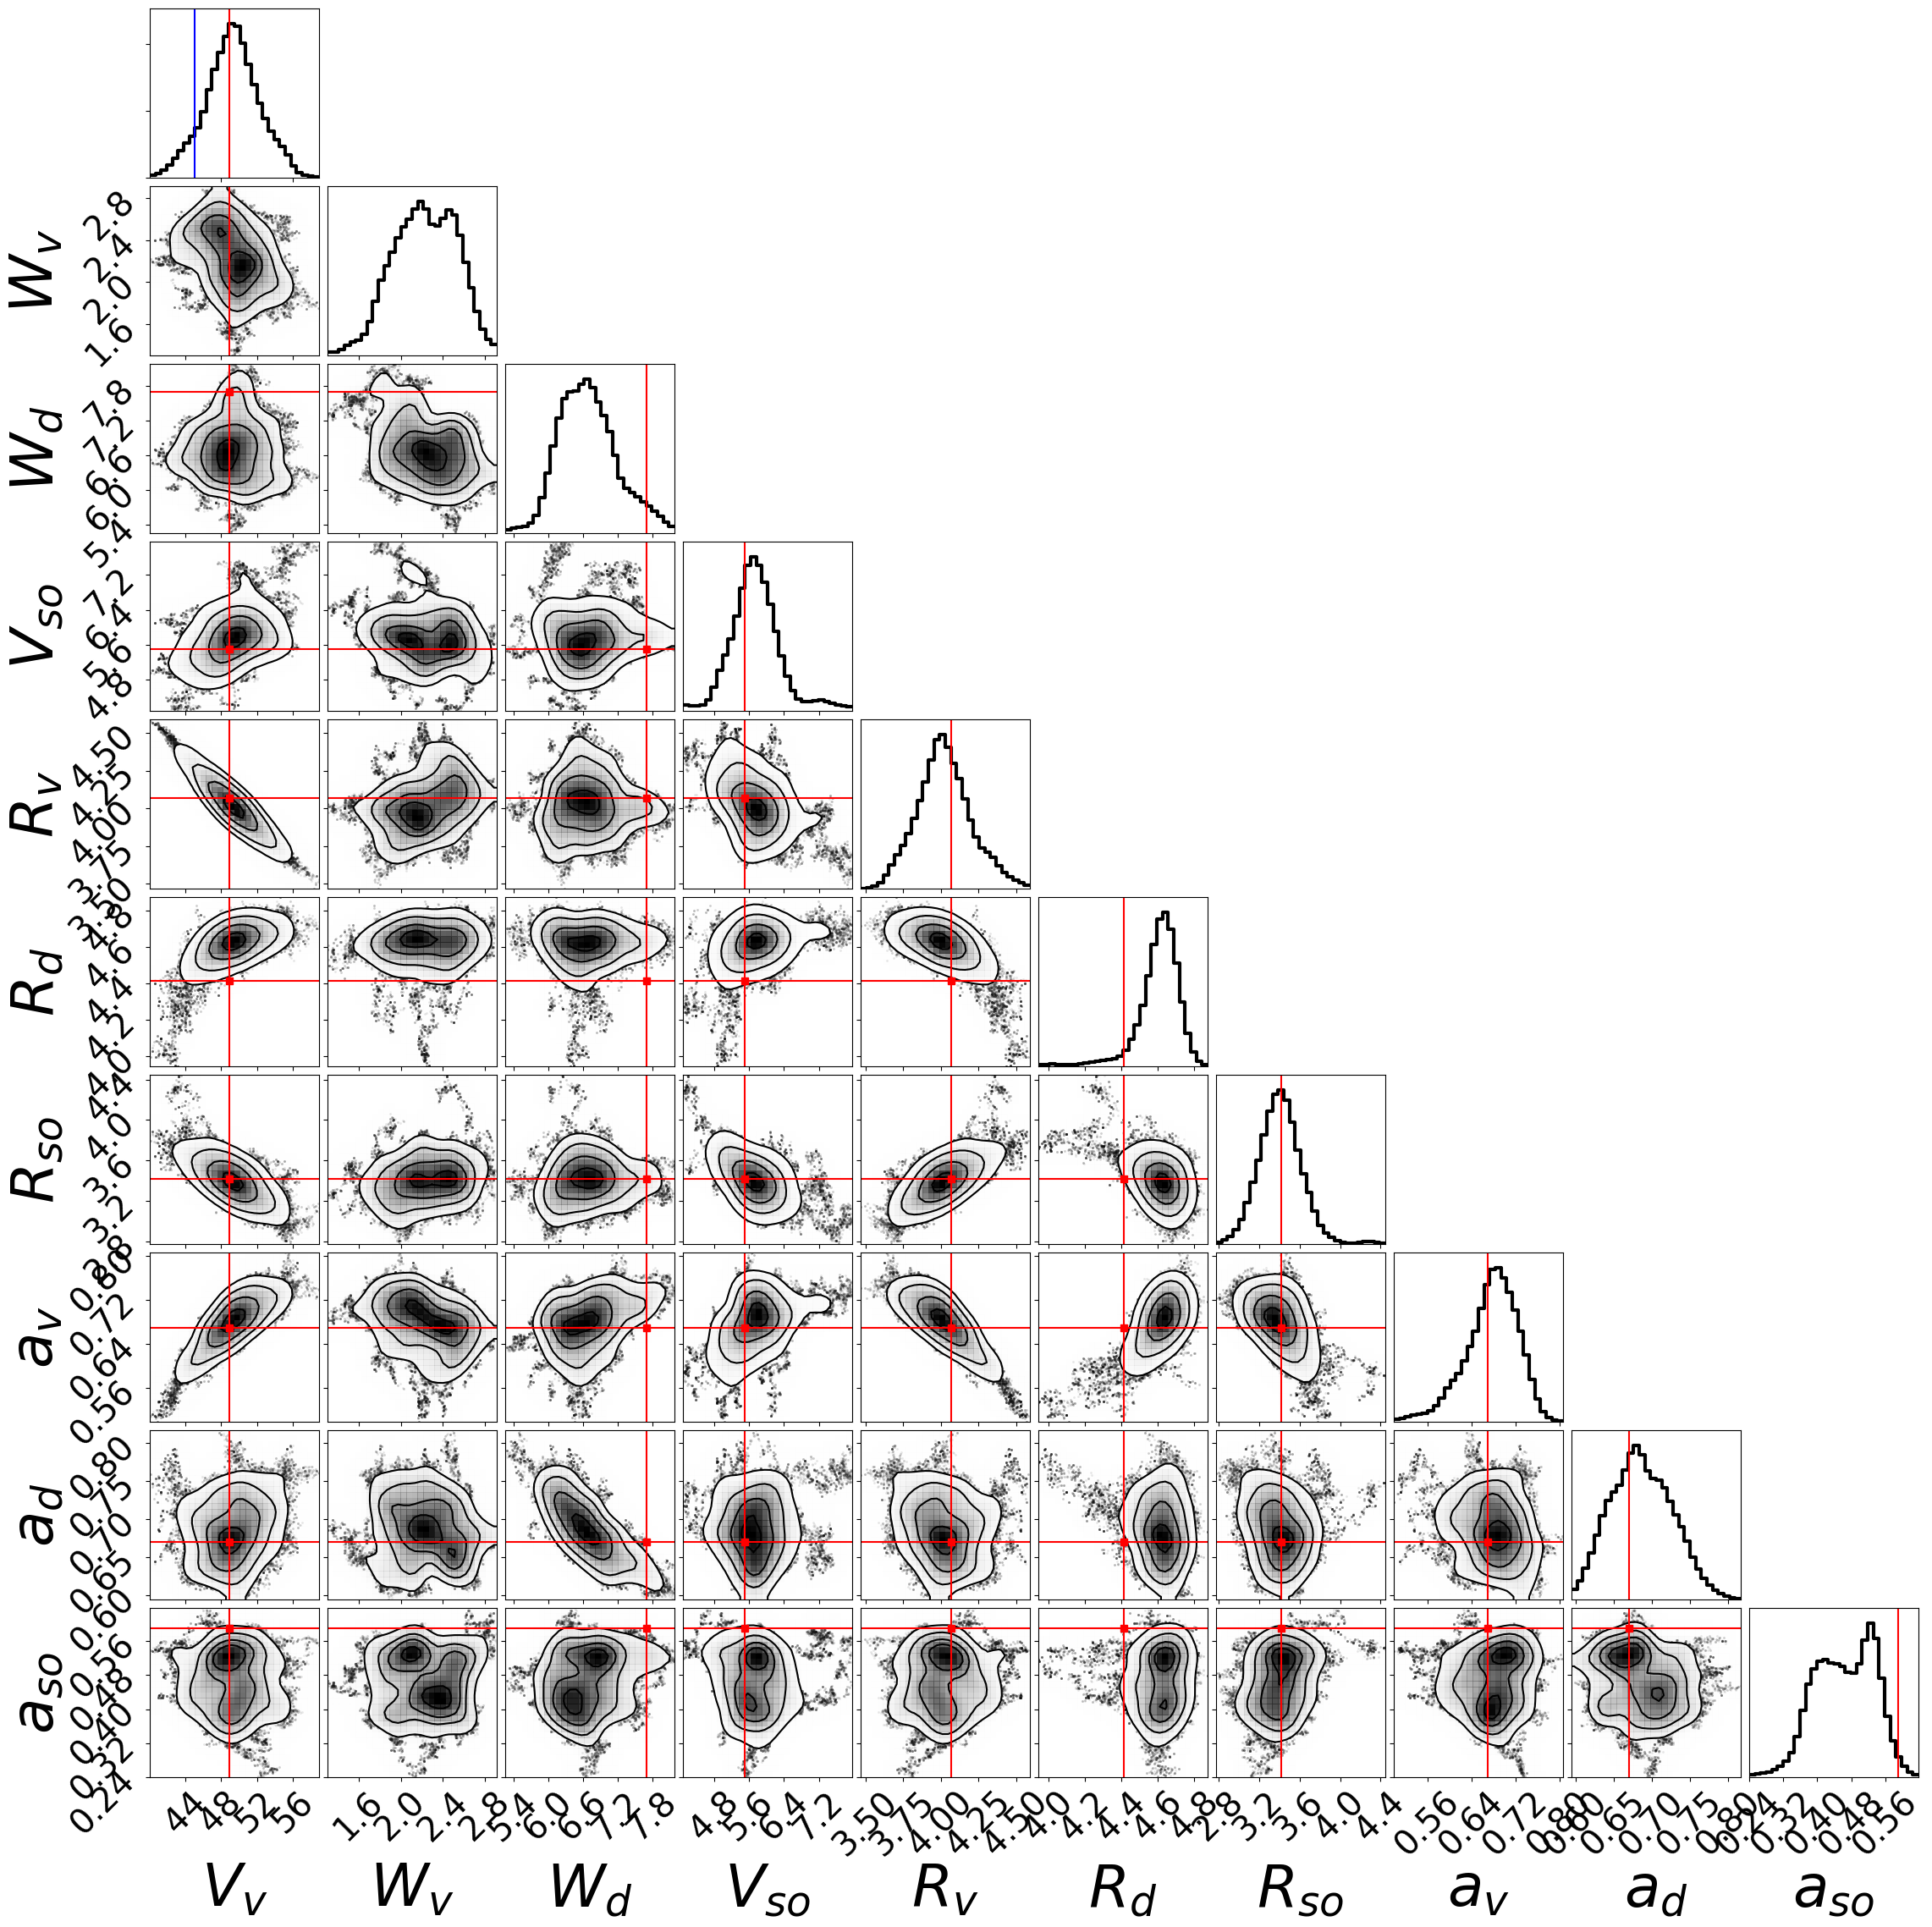

In [42]:
# The plotting routinge to make the gorgeous corner plots! For some reason we have to run it twice to make the label
# size for the ticks to be correct

plt.rc("xtick", labelsize=29)
plt.rc("ytick", labelsize=29)

bins_target=30
ws = [abs(max(all_chains[:,i])-min(all_chains[:,i]))/bins_target for i in range(len(all_chains.T))]

# figure=corner.corner(samples_prior,
#     labels=[
#         "$V_v$",
#         "$W_v$",
#         "$W_d$",
#         "$V_{so}$",
# #         "$W_{so}$",
#         "$R_v$",
#         "$R_d$",
#         "$R_{so}$",
#         "$a_v$",
#         "$a_d$",
#         "$a_{so}$"
#     ],
#     labelpad=0.2,
#     weights=np.full(len(samples_prior),(len(all_chains))/(len(samples_prior))),
#     bins=[int(abs(max(samples_prior[:,i])-min(samples_prior[:,i]))/ws[i]) for i in range(len(samples_prior.T))],
#     color='b',
#     # bins=20,
#     label_kwargs={"fontsize": 50},
#     hist_kwargs={"linewidth": 3},
#     quantiles=None,
#     truths=alphaCentral,
#     truth_color="cyan",
#     smooth=(1.7),
#     smooth1d=1.0
# )


# corner.corner(
#     all_chains,fig=figure,
figure=corner.corner(all_chains,
    labels=[
        "$V_v$",
        "$W_v$",
        "$W_d$",
        "$V_{so}$",
#         "$W_{so}$",
        "$R_v$",
        "$R_d$",
        "$R_{so}$",
        "$a_v$",
        "$a_d$",
        "$a_{so}$"
    ],
    labelpad=0.2,
    # bins=20,
    bins=[int(abs(max(all_chains[:,i])-min(all_chains[:,i]))/ws[i]) for i in range(len(all_chains.T))],
    label_kwargs={"fontsize": 50},
    hist_kwargs={"linewidth": 3},
    quantiles=None,
    truths=alphaKD,
    truth_color="r",
    smooth=(1.7),
    smooth1d=1.0
)


dim=len(all_chains[0]) 
ranges=[[min(all_chains[:,i]),max(all_chains[:,i])] for i in range(len(all_chains.T))]


axes = np.array(figure.axes).reshape((dim, dim))
max_ticks=3
# print()
for i in range(dim):
    ax = axes[i, i]
    ax.xaxis.set_major_locator(MaxNLocator(max_ticks))
    ax.yaxis.set_major_locator(MaxNLocator(max_ticks))
    ax.set_xlim(ranges[i][0],ranges[i][1])
    ax.axvline(alphaCentral[i], color="blue")
   

    x_grid=np.linspace(ranges[i][0],ranges[i][1],200)
    ax.plot(x_grid,len(all_chains)*ws[i]*sps.normpdf(x_grid, alphaCentral[i], SigmasPrior[i]),color='b',linewidth=2)
    ax.fill_between(x_grid, len(all_chains)*ws[i]*sps.normpdf(x_grid, alphaCentral[i], SigmasPrior[i]), color='blue', alpha=0.1)
    ax.xaxis.set_major_locator(MaxNLocator(max_ticks))
    ax.yaxis.set_major_locator(MaxNLocator(max_ticks))



    for j in range(i):
        ax.xaxis.set_major_locator(MaxNLocator(max_ticks))
        ax.yaxis.set_major_locator(MaxNLocator(max_ticks))
        ax = axes[i, j]
        ax.set_ylim(ranges[i][0],ranges[i][1])
        ax.set_xlim(ranges[j][0],ranges[j][1])
        
        
        ax.axvline(alphaCentral[i], color="blue")
        ax.axhline(alphaCentral[j], color="blue")
        ax.plot(alphaCentral[i], alphaCentral[j], "sb")
        
        
        ax.axvline(alphaCentral[j], color="blue")
        ax.axhline(alphaCentral[i], color="blue")
        ax.plot(alphaCentral[j], alphaCentral[i], "sb")
        ax.xaxis.set_major_locator(MaxNLocator(max_ticks))
        ax.yaxis.set_major_locator(MaxNLocator(max_ticks))
        




width = 24
height = 18
figure.set_size_inches(width, height)

plt.show()
